<a href="https://colab.research.google.com/github/sa96102/Python_exam/blob/master/Stock_LSTM_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

Using TensorFlow backend.


#Samsung Electronics Stock

### Load Dataset

In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Python_exam/Data/005930.KS.csv')
data.head()
# print(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-03-18,29920.0,30120.0,29720.0,30060.0,291.512238,12464350.0
1,2015-03-19,30200.0,30200.0,29400.0,29400.0,285.111786,13225800.0
2,2015-03-20,29500.0,29600.0,29200.0,29280.0,283.948120,12704950.0
3,2015-03-23,29240.0,29480.0,29160.0,29340.0,284.529907,8122900.0
4,2015-03-24,29100.0,29560.0,29100.0,29520.0,286.275543,9113150.0


### Drop Null

In [4]:
data= data.dropna()
print(data)

            Date     Open     High      Low    Close     Adj Close      Volume
0     2015-03-18  29920.0  30120.0  29720.0  30060.0    291.512238  12464350.0
1     2015-03-19  30200.0  30200.0  29400.0  29400.0    285.111786  13225800.0
2     2015-03-20  29500.0  29600.0  29200.0  29280.0    283.948120  12704950.0
3     2015-03-23  29240.0  29480.0  29160.0  29340.0    284.529907   8122900.0
4     2015-03-24  29100.0  29560.0  29100.0  29520.0    286.275543   9113150.0
...          ...      ...      ...      ...      ...           ...         ...
1221  2020-03-09  56500.0  56500.0  56500.0  56500.0  56500.000000         0.0
1222  2020-03-10  53800.0  54900.0  53700.0  54600.0  54600.000000  32106554.0
1223  2020-03-11  54300.0  54400.0  52000.0  52100.0  52100.000000  45707281.0
1224  2020-03-12  52100.0  52100.0  52100.0  52100.0  52100.000000         0.0
1228  2020-03-18  47750.0  48350.0  47200.0  47550.0  47550.000000  25523340.0

[1221 rows x 7 columns]


### Compute Mid Price

In [0]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

### Create Windows

In [0]:
seq_len = 50 # windows size.
sequence_length = seq_len + 1 # 앞의 50개를 확인하고 뒤의 1개를 예측함. 따라서 windows에 들어가는 데이터 개수는 총 51개.

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length]) # for문을 통해 result라는 리스트에 51개씩 1 step씩 넘어가며 저장.

### Normlize Data

In [7]:
normalized_data = [] # 모델이 좀 더 예측하기 쉽도록 정규화.
for window in result:
    normalized_window = [((float(p)/float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9)) # training set을 90% 사용, test set을 10% 사용.
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1053, 50, 1), (117, 50, 1))

### Build a Model

In [8]:
model = Sequential() # keras.models.Sequential()_모델을 순차적으로 정의하는 클래스.

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1))) # model.add_모델에 레이어를 추가. input은 50개. 유닛 수는 50.
# keras.layers.LSTM()_LSTM 레이어.

model.add(LSTM(64, return_sequences=False)) # 유닛 수는 64. 조절.

model.add(Dense(1, activation='linear')) # 다음 날 하루의 데이터를 예측.
# keras.layers.Dense()_Fully connected layer.

model.compile(loss='mse', optimizer='rmsprop') # loss function은 Mean Squared Error.

model.summary() # 모델의 개요를 출력.





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


### Training

In [9]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=10, epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1053 samples, validate on 117 samples
Epoch 1/20





1053/1053 [==============================] - 8s 7ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 2/20
1053/1053 [==============================] - 6s 6ms/step - loss: 6.8570e-04 - val_loss: 0.0011
Epoch 3/20
1053/1053 [==============================] - 7s 6ms/step - loss: 5.2196e-04 - val_loss: 0.0014
Epoch 4/20
1053/1053 [==============================] - 7s 7ms/step - loss: 4.0584e-04 - val_loss: 3.8806e-04
Epoch 5/20
1053/1053 [==============================] - 7s 6ms/step - loss: 3.2100e-04 - val_loss: 3.3669e-04
Epoch 6/20
1053/1053 [==============================] - 7s 6ms/step - loss: 2.6941e-04 - val_loss: 2.9353e-04
Epoch 7/20
1053/1053 [==============================] - 7s 6ms/step - loss: 2.5290e-04 - val_loss: 4.4778e-04
Epoch 8/20
1053/1053 [==============================] - 7s 7ms/step - loss: 2.3942e-04 - val_loss

### Prediction

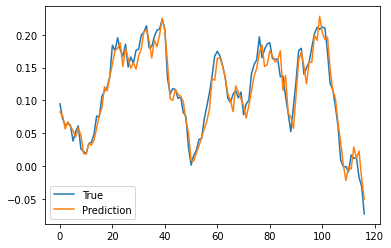

In [10]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

#Ethereum

In [11]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Python_exam/Data/Ethereum.csv')
data.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,18-Mar-19,140.10,142.27,138.84,139.37,"4,551,739,879","14,675,181,094"
1,19-Mar-19,139.25,140.99,139.14,140.52,"4,251,488,129","14,797,612,389"
2,20-Mar-19,140.48,140.95,138.31,140.69,"4,664,134,462","14,817,151,375"
3,21-Mar-19,140.48,141.00,135.86,136.64,"5,087,247,796","14,392,427,839"
4,22-Mar-19,136.56,138.79,136.23,137.18,"4,490,899,266","14,451,740,115"


In [0]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [0]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [14]:
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((284, 50, 1), (31, 50, 1))

In [15]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(x_train, y_train, validation_data=(x_test, y_test),batch_size=10, epochs=20)

Train on 284 samples, validate on 31 samples
Epoch 1/20
284/284 [==============================] - 3s 10ms/step - loss: 0.0319 - val_loss: 0.0931
Epoch 2/20
284/284 [==============================] - 2s 6ms/step - loss: 0.0129 - val_loss: 0.0490
Epoch 3/20
284/284 [==============================] - 2s 6ms/step - loss: 0.0104 - val_loss: 0.1672
Epoch 4/20
284/284 [==============================] - 2s 6ms/step - loss: 0.0083 - val_loss: 0.0947
Epoch 5/20
284/284 [==============================] - 2s 6ms/step - loss: 0.0068 - val_loss: 0.0290
Epoch 6/20
284/284 [==============================] - 2s 6ms/step - loss: 0.0061 - val_loss: 0.0317
Epoch 7/20
284/284 [==============================] - 2s 6ms/step - loss: 0.0058 - val_loss: 0.0385
Epoch 8/20
284/284 [==============================] - 2s 6ms/step - loss: 0.0060 - val_loss: 0.0864
Epoch 9/20
284/284 [==============================] - 2s 6ms/step - loss: 0.0052 - val_loss: 0.0195
Epoch 10/20
284/284 [==============================] -

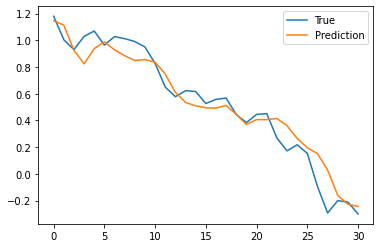

In [17]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()